# **Session #4 Homework**

In [77]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [78]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers.De-coding them:

In [79]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables

In [80]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [81]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [82]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

What are the categorical variables? What are the numerical?

In [83]:
categorical = list(df.select_dtypes(include="object").columns)
categorical 

['home', 'marital', 'records', 'job']

In [84]:
Numerical = list(df.drop("default", axis=1).select_dtypes(exclude="object").columns)
Numerical

['seniority',
 'time',
 'age',
 'expenses',
 'income',
 'assets',
 'debt',
 'amount',
 'price']

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [85]:
from sklearn.model_selection import train_test_split

df_full_train,df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)


### **Question 1**


ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

   - For each numerical variable, use it as score and compute AUC with the "default" variable
   - Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [86]:
from sklearn.metrics import roc_auc_score

for col in df.drop("default", axis=1).select_dtypes(exclude="object").columns:
    auc_score = roc_auc_score(df_train.default,df_train[col])
    if auc_score < 0.5:
        auc_score = roc_auc_score(df_train.default, -df_train[col])
    print(f'{col:<10}: {auc_score:.4f}')   

seniority : 0.7094
time      : 0.5609
age       : 0.5733
expenses  : 0.5009
income    : 0.6820
assets    : 0.6486
debt      : 0.5048
amount    : 0.5911
price     : 0.5043



Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

Training the model

From now on, use these columns only:

            ['seniority', 'income', 'assets', 'records', 'job', 'home']

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

            LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)



In [90]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']

In [91]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

dv = DictVectorizer(sparse=False)

train_dict = df_train[features].to_dict(orient='records')
val_dict = df_val[features].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

y_train = df_train.default
y_val = df_val.default


model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)


predict = model.predict_proba(X_val)[:, 1]


### **Question 2**

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812



In [92]:
auc_score = roc_auc_score(y_val, predict)
round(auc_score, 3)

0.811

### **Question 3**

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them



In [93]:
thresholds = np.linspace(0,1,101)
thres = []
print(thresholds)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]


In [94]:
for step in thresholds:
    actual_pos = (y_val == 1)
    actual_neg = (y_val == 0)
    predict_pos = (predict >= step)
    predict_neg = (predict < step)
    
    tp = (predict_pos & actual_pos).sum()
    tn = (predict_neg & actual_neg).sum()
    
    fp = (predict_pos & actual_neg).sum()
    fn = (predict_neg & actual_pos).sum()
    
    precision = tp / (tp+fp)
    recall = tp / (tp+fn)
    f1 = 2*precision*recall/(precision+recall)
    
    thres.append([step,precision,recall,f1])
    
df_scores = pd.DataFrame(thres, columns = ['threshold', 'precision', 'recall','f1'])
df_scores

,threshold,precision,recall,f1
0,0.00,0.276094,1.00000,0.432718
1,0.01,0.279228,1.00000,0.436557
2,0.02,0.285714,0.99187,0.443636
3,0.03,0.290516,0.98374,0.448563
4,0.04,0.300995,0.98374,0.460952
...,...,...,...,...
96,0.96,NaN,0.00000,NaN
97,0.97,NaN,0.00000,NaN
98,0.98,NaN,0.00000,NaN
99,0.99,NaN,0.00000,NaN


At which threshold precision and recall curves intersect?

- 0.2
- 0.4
- 0.6
- 0.8



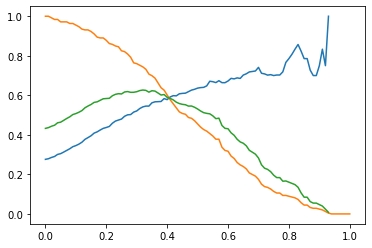

In [95]:
plt.plot(df_scores.threshold, df_scores.precision, label = 'precision')
plt.plot(df_scores.threshold, df_scores.recall, label = 'recall')
plt.plot(df_scores.threshold, df_scores.f1, label = 'f1-score')
plt.show()

### **Question 4**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:
$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [96]:
df_scores[["f1"]].max()

f1    0.626712
dtype: float64

In [58]:
df_scores.iloc[df_scores['f1'].argmax(), 0]

0.32

### **Question 5**


Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

In [97]:
from sklearn.model_selection import KFold

score = list()


kfold = KFold(n_splits=5, shuffle=True, random_state=1)


for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train)):
        
        
        new_train = df_full_train.iloc[train_idx]
        new_val = df_full_train.iloc[val_idx]

        y_train = new_train.default.values
        y_val = new_val.default.values
        
       
        train_dict = new_train[features].to_dict(orient='records')
        val_dict = new_val[features].to_dict(orient='records')
        
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dict)
        X_val = dv.transform(val_dict)        
       
        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_train, y_train)
      
        y_pred = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        score.append(auc)

        print(f'fold {fold} roc-auc score: {auc:.4f}')

fold 0 roc-auc score: 0.8256
fold 1 roc-auc score: 0.8254
fold 2 roc-auc score: 0.7879
fold 3 roc-auc score: 0.8250
fold 4 roc-auc score: 0.8055


In [98]:
round(np.std(score), 3)

0.015

### **Question 6**

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 1, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [106]:


C_values = [0.01, 0.1, 1, 10]
score = list()

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for C in C_values:
    kfold_scores = list()
    
    for train_idx, val_idx in kfold.split(df_full_train):
            
            df_train = df_full_train.iloc[train_idx, :]
            df_val = df_full_train.iloc[val_idx, :]
            y_train = df_train.default.values
            y_val = df_val.default.values

            train_dict = df_train[features].to_dict(orient='records')
            val_dict = df_val[features].to_dict(orient='records')
        
            dv = DictVectorizer(sparse=False)
            X_train = dv.fit_transform(train_dict)
            X_val = dv.transform(val_dict)

            model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
            model.fit(X_train, y_train)

            y_pred = model.predict_proba(X_val)[:, 1]
            auc = roc_auc_score(y_val, y_pred)
            
            kfold_scores.append(auc)
            
    
    
    mean_score = np.mean(kfold_scores)
    std = np.std(kfold_scores)    
    kfold_scores.extend([mean_auc, std])
    score.append(kfold_scores)
    
    print(f'C values={C:<5} mean_roc-auc: {mean_score:.4f} +/- {std:.3f}')

C values=0.01  mean_roc-auc: 0.8086 +/- 0.013
C values=0.1   mean_roc-auc: 0.8129 +/- 0.014
C values=1     mean_roc-auc: 0.8139 +/- 0.015
C values=10    mean_roc-auc: 0.8139 +/- 0.014


In [109]:
smallest = pd.DataFrame(scores, columns=['fold_1', 'fold_2', 'fold_3', 'fold_4', 
                                        'fold_5', 'mean_score', 'std'], 
                       index=[str(c) for c in C_values]).rename_axis('C values')

In [110]:
smallest.mean_score.idxmax()

'1'

#                                                 **DONE**